# XGBoost for Cancellation Prediction

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import TargetEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV

c:\Users\Sebastijan\anaconda3\envs\hotel_management\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset import

In [7]:
data = pd.read_parquet("../../data/hotel_booking_optimized.parquet")
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119389 entries, 0 to 119388
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119389 non-null  category      
 1   is_canceled                     119389 non-null  int8          
 2   lead_time                       119389 non-null  int16         
 3   arrival_date_year               119389 non-null  int16         
 4   arrival_date_month              119389 non-null  category      
 5   arrival_date_week_number        119389 non-null  int8          
 6   arrival_date_day_of_month       119389 non-null  int8          
 7   stays_in_weekend_nights         119389 non-null  int8          
 8   stays_in_week_nights            119389 non-null  int8          
 9   adults                          119389 non-null  int16         
 10  children                        119389 non-null  int8   

We can confirm hereby that the memory usage has successfully been brought under 50MB, which is good.

## Features

We first need to decide what columns will be relevant for training this model.

Let's first see if there are any differences in cancellation rates between our two hotels.

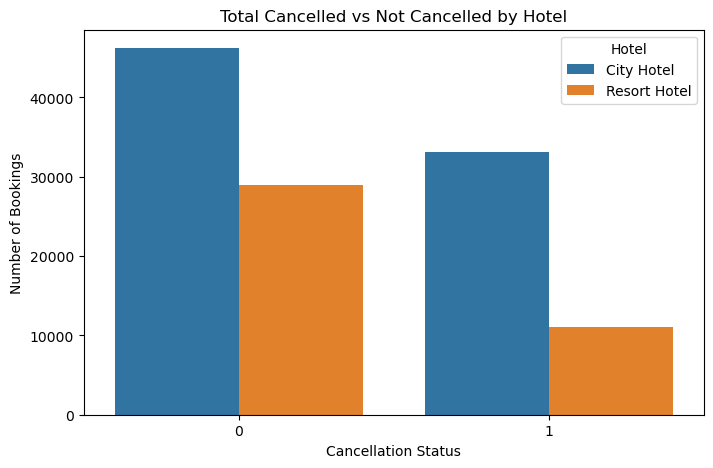

In [3]:
# total cancelled vs not cancelled by hotel
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x="is_canceled", hue="hotel")
plt.title("Total Cancelled vs Not Cancelled by Hotel")
plt.xlabel("Cancellation Status")
plt.ylabel("Number of Bookings")
plt.legend(title="Hotel")
plt.show();

In [4]:
data.groupby("hotel", observed=False)["is_canceled"].value_counts(normalize=True).unstack()

is_canceled,0,1
hotel,,
City Hotel,0.58273,0.41727
Resort Hotel,0.72236,0.27764


There are indeed some differences. Worth noting.

Now let's decide what to do with each of the columns.

In [5]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'name', 'email',
       'phone-number', 'credit_card'],
      dtype='object')

In [6]:
# total columns

len(data.columns)

36

In [7]:
# Columns



# Drop columns based on relevance, sensitivity, and potential data leakage

# name -> irrelevant, sensitive
# email -> irrelevant, sensitive
# phone-number -> irrelevant, sensitive
# credit_card -> sensitive, not predictive
# reservation_status -> data leakage
# reservation_status_date -> potential data leakage
# assigned_room_type -> potential data leakage
# company -> high missing values (over 90% missing)
# reserved_room_type -> not suitable for prearrival prediction
# booking_changes -> not suitable for prearrival prediction


# one-hot encode categorical columns with low cardinality

# hotel -> two hotels, perfect for one-hot encoding
# meal -> few categories, suitable for one-hot encoding
# market_segment -> few categories, suitable for one-hot encoding
# distribution_channel -> few categories, suitable for one-hot encoding
# customer_type -> few categories, suitable for one-hot encoding
# deposit_type -> few categories, suitable for one-hot encoding
# arrival_date_month -> 12 months, suitable for one-hot encoding


# target encoding for high cardinality categorical columns

# agent -> high cardinality, target encoding preferred
# country -> high cardinality, target encoding preferred


# columns to leave numeric / passhthrough

# lead_time -> number of days before arrival, leave as is
# arrival_date_year -> year of arrival, leave as is
# arrival_date_week_number -> week number of arrival, leave as is
# arrival_date_day_of_month -> day of month of arrival, less predictive, but leave as is
# stays_in_weekend_nights -> number of weekend nights booked, leave as is
# stays_in_week_nights -> number of week nights booked, leave as is
# adults -> number of adults, leave as is
# children -> number of children, leave as is
# babies -> number of babies, leave as is
# previous_cancellations -> number of previous cancellations, leave as is
# previous_bookings_not_canceled -> number of previous non-canceled bookings, leave as is
# days_in_waiting_list -> number of days in waiting list, leave as is
# adr -> average daily rate, leave as is
# required_car_parking_spaces -> number of parking spaces required, leave as is
# total_of_special_requests -> number of special requests made, leave as is
# is_repeated_guest -> whether the guest is a repeat guest, leave as is


# target variable

# is_canceled

The missing values in agent and country should be handled with -1 before target encoding.

Let's explore some feature engineering ideas.

In [8]:
# total_stay = stays_in_weekend_nights + stays_in_week_nights
# adr_per_person = adr / (adults + children + babies)
# season/quarter based on arrival_date_month or arrival_date_week_number
# hotel * lead_time interaction
# hotel * agent interaction

Now let's double check if there is any significant imbalance between our two classes in the target variable.

In [9]:
data["is_canceled"].value_counts(normalize=True)

is_canceled
0    0.629581
1    0.370419
Name: proportion, dtype: float64

This is fine. We will optimize for roc_auc during training and then look for an optimal f1 threshold later on.

## Pipeline

### Defining the columns (based on the commented decisions above)

In [10]:
# Columns for one-hot encoding (low-cardinality categorical)
onehot_cols = [
    "hotel", "meal", "market_segment", "distribution_channel",
    "customer_type", "deposit_type", "arrival_date_month"
]

# Columns for target encoding (high-cardinality categorical)
target_cols = ["agent", "country"]

# Numeric / passthrough columns
numeric_cols = [
    "lead_time", "arrival_date_year", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights", "stays_in_week_nights",
    "adults", "children", "babies", "previous_cancellations",
    "previous_bookings_not_canceled", "days_in_waiting_list",
    "adr", "required_car_parking_spaces", "total_of_special_requests",
    "is_repeated_guest"
]

# Unincluded columns will be dropped in the preprocessing step

### Preprocessing pipeline

In [11]:
# Target encoding for high-cardinality categorical features
target_encoder = TargetEncoder(cols=target_cols, smoothing=5)  # CV-safe inside pipeline

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("target", target_encoder, target_cols),
        ("onehot", OneHotEncoder(handle_unknown="ignore"), onehot_cols),
        ("numeric", "passthrough", numeric_cols)
    ]
)

### Pipeline build

In [12]:
# XGBoost Classifier with GPU support inside a Pipeline - will need an appropriate GPU setup
# Here, RTX 5070 Ti will be used

pipeline = Pipeline([
    # preprocessing step
    ("preprocessing", preprocessor),

    # model step
    ("model", XGBClassifier(
        # Use GPU
        tree_method="hist",
        device="cuda",

        # Basic hyperparameters, will be overridden in hyperparameter tuning
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        eval_metric="logloss"
    ))
])

### Train/test split

In [8]:
X = data.drop("is_canceled", axis=1)
y = data["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### Useful method for f1 search later on

In [14]:
def optimal_f1_search(y_true, y_probs):
    
    thresholds = np.linspace(0,1,101)
    f1_scores = []

    for t in thresholds:
        y_pred_thresh = (y_probs >= t).astype(int)
        f1_scores.append(f1_score(y_true, y_pred_thresh))

    best_idx = np.argmax(f1_scores)
    print("Best threshold:", thresholds[best_idx])
    print("Best F1:", f1_scores[best_idx])

    plt.plot(thresholds, f1_scores)
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs Decision Threshold")
    plt.show()

## Naive model for reference

In [15]:
untuned_xgb_pipeline = pipeline.fit(X_train, y_train)
untuned_xgb_pipeline

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('target', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [16]:
y_pred_train = untuned_xgb_pipeline.predict(X_train)
y_pred_test = untuned_xgb_pipeline.predict(X_test)

c:\Users\Sebastijan\anaconda3\envs\hotel_management\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:20:33] WARNING: D:\bld\xgboost-split_1744329000128\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


#### Naive model evaluation

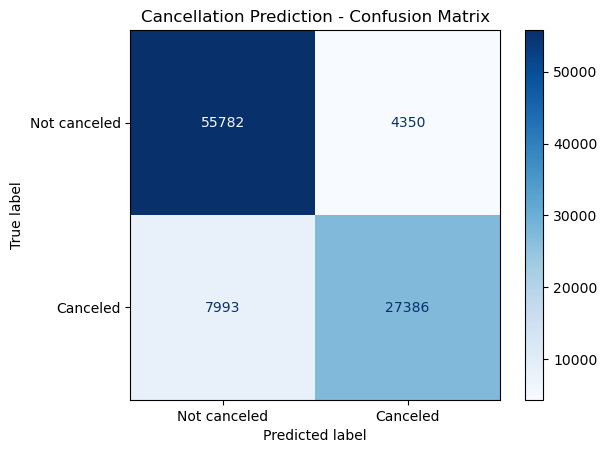

              precision    recall  f1-score   support

Not canceled       0.87      0.93      0.90     60132
    Canceled       0.86      0.77      0.82     35379

    accuracy                           0.87     95511
   macro avg       0.87      0.85      0.86     95511
weighted avg       0.87      0.87      0.87     95511



In [17]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None  # can also do 'true' to normalize by row
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_train, y_pred_train, target_names=["Not canceled", "Canceled"]))

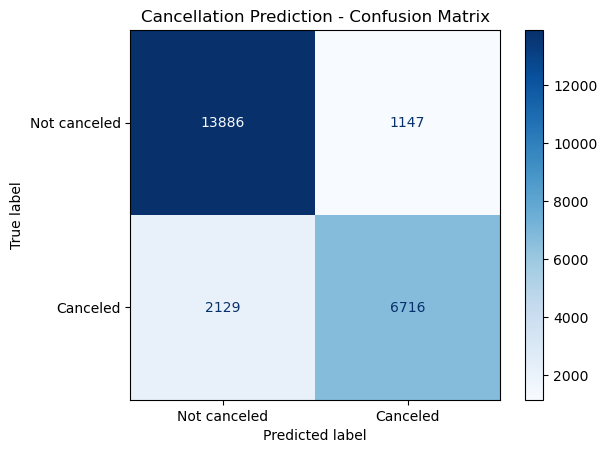

              precision    recall  f1-score   support

Not canceled       0.87      0.92      0.89     15033
    Canceled       0.85      0.76      0.80      8845

    accuracy                           0.86     23878
   macro avg       0.86      0.84      0.85     23878
weighted avg       0.86      0.86      0.86     23878



In [18]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_test, y_pred_test, target_names=["Not canceled", "Canceled"]))

ROC-AUC: 0.9389660929486315


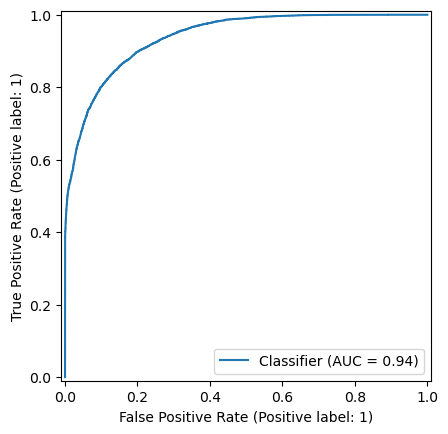

In [19]:
y_probs = untuned_xgb_pipeline.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_probs)
print("ROC-AUC:", auc)

RocCurveDisplay.from_predictions(y_test, y_probs)
plt.show();

In [20]:
feature_names = untuned_xgb_pipeline.named_steps["preprocessing"].get_feature_names_out()
untuned_xgb_model = untuned_xgb_pipeline.named_steps['model']
importances = untuned_xgb_model.feature_importances_

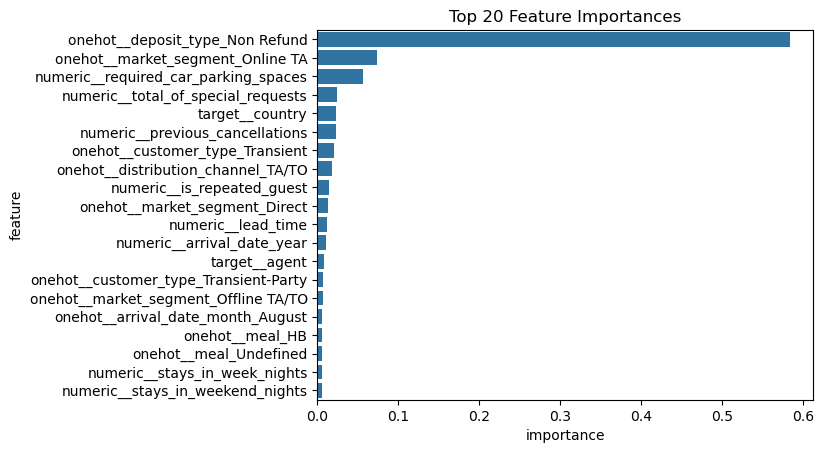

In [21]:
df_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)

sns.barplot(x='importance', y='feature', data=df_imp)
plt.title("Top 20 Feature Importances")
plt.show();

In [22]:
irrelevant_features = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).loc[importances == 0]

irrelevant_features

,feature,importance
3,onehot__hotel_Resort Hotel,0.0
16,onehot__market_segment_Undefined,0.0
21,onehot__distribution_channel_Undefined,0.0
28,onehot__deposit_type_Refundable,0.0


## First model with hyperparameter tuning

In [23]:
param_dist = {
    "model__n_estimators": [200, 300, 400, 500],
    "model__max_depth": [4, 6, 8, 10],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__gamma": [0, 1, 5]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=100,
    cv=3,
    scoring="roc_auc",
    verbose=2,
    n_jobs=1, # Use 1 to avoid potential GPU conflicts
    random_state=42
)

random_search.fit(X_train, y_train)

tuned_xgb_pipeline = random_search.best_estimator_
tuned_xgb_pipeline

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=500, model__subsample=1.0; total time=   1.4s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=500, model__subsample=1.0; total time=   1.4s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=6, model__n_estimators=500, model__subsample=1.0; total time=   1.4s
[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.05, model__max_depth=4, model__n_estimators=200, model__subsample=0.8; total time=   0.5s
[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.05, model__max_depth=4, model__n_estimators=200, model__subsample=0.8; total time=   0.5s
[CV] END model__colsample_bytree=1.0, model__gamma=0, model__learning_rate=0.05, model__max_depth=4, m

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('target', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [24]:
y_pred_train = tuned_xgb_pipeline.predict(X_train)
y_pred_test = tuned_xgb_pipeline.predict(X_test)

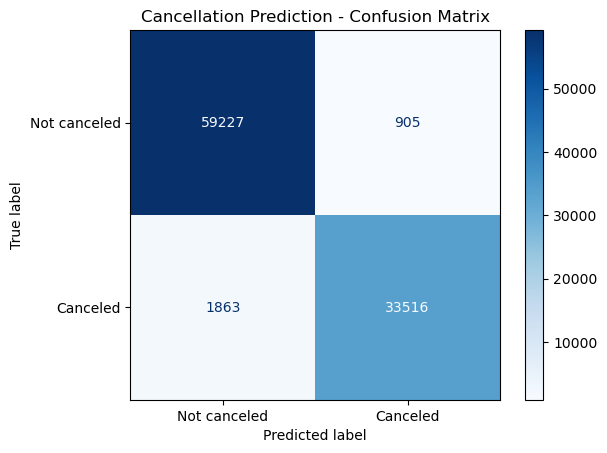

              precision    recall  f1-score   support

Not canceled       0.97      0.98      0.98     60132
    Canceled       0.97      0.95      0.96     35379

    accuracy                           0.97     95511
   macro avg       0.97      0.97      0.97     95511
weighted avg       0.97      0.97      0.97     95511



In [25]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None  # can also do 'true' to normalize by row
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_train, y_pred_train, target_names=["Not canceled", "Canceled"]))

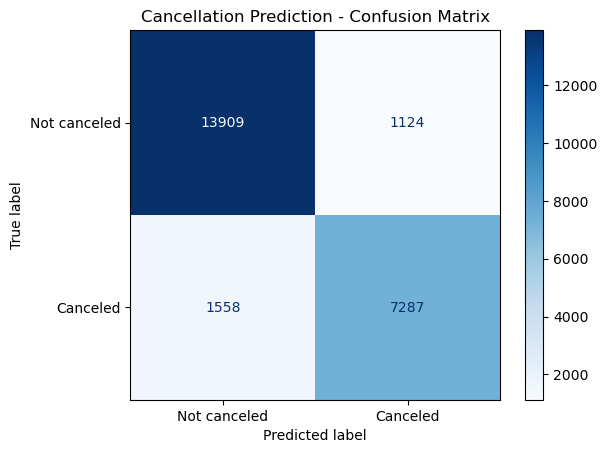

              precision    recall  f1-score   support

Not canceled       0.90      0.93      0.91     15033
    Canceled       0.87      0.82      0.84      8845

    accuracy                           0.89     23878
   macro avg       0.88      0.87      0.88     23878
weighted avg       0.89      0.89      0.89     23878



In [26]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_test, y_pred_test, target_names=["Not canceled", "Canceled"]))

In [27]:
random_search.best_params_

{'model__subsample': 1.0,
 'model__n_estimators': 400,
 'model__max_depth': 10,
 'model__learning_rate': 0.2,
 'model__gamma': 0,
 'model__colsample_bytree': 0.8}

ROC-AUC: 0.955492880802615


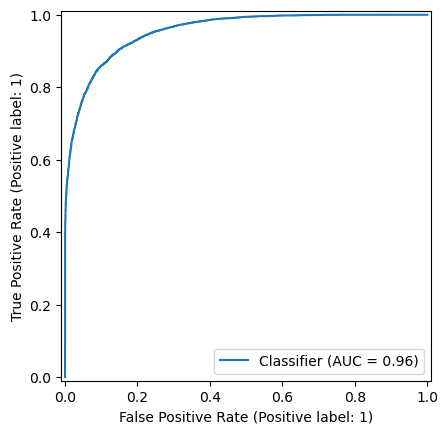

In [28]:
y_probs = tuned_xgb_pipeline.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_probs)
print("ROC-AUC:", auc)

RocCurveDisplay.from_predictions(y_test, y_probs)
plt.show();

The model is better, but there is some overfitting.

## Second model with hyperparameter tuning

Let's add some parameters meant to deal with the overfitting.

In [29]:
param_dist_2 = {
    "model__n_estimators": [300, 500, 700],
    
    # Shallower trees to avoid overfitting
    "model__max_depth": [3, 4, 6],

    # Lower learning rate so trees are less aggressive
    "model__learning_rate": [0.01, 0.05, 0.1],

    # Regularization
    "model__min_child_weight": [3, 5, 10],
    "model__gamma": [0, 1, 5],

    # Subsampling to prevent memorization
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],

    # L1/L2 regularization
    "model__reg_alpha": [0, 0.1, 1],
    "model__reg_lambda": [1, 2, 5],
}

random_search_2 = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist_2,
    n_iter=100,
    cv=3,
    scoring="roc_auc",
    verbose=2,
    n_jobs=1, # Use 1 to avoid potential GPU conflicts
    random_state=42
)

random_search_2.fit(X_train, y_train)

tuned_xgb_pipeline_2 = random_search_2.best_estimator_
tuned_xgb_pipeline_2


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END model__colsample_bytree=1.0, model__gamma=1, model__learning_rate=0.01, model__max_depth=6, model__min_child_weight=3, model__n_estimators=300, model__reg_alpha=0, model__reg_lambda=1, model__subsample=0.7; total time=   0.8s
[CV] END model__colsample_bytree=1.0, model__gamma=1, model__learning_rate=0.01, model__max_depth=6, model__min_child_weight=3, model__n_estimators=300, model__reg_alpha=0, model__reg_lambda=1, model__subsample=0.7; total time=   0.8s
[CV] END model__colsample_bytree=1.0, model__gamma=1, model__learning_rate=0.01, model__max_depth=6, model__min_child_weight=3, model__n_estimators=300, model__reg_alpha=0, model__reg_lambda=1, model__subsample=0.7; total time=   0.8s
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.05, model__max_depth=3, model__min_child_weight=5, model__n_estimators=500, model__reg_alpha=1, model__reg_lambda=2, model__subsample=1.0; total time=   0.

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('target', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [30]:
y_pred_train = tuned_xgb_pipeline_2.predict(X_train)
y_pred_test = tuned_xgb_pipeline_2.predict(X_test)

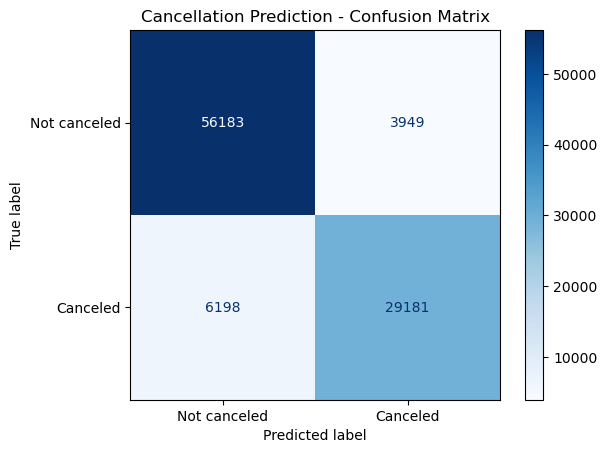

              precision    recall  f1-score   support

Not canceled       0.90      0.93      0.92     60132
    Canceled       0.88      0.82      0.85     35379

    accuracy                           0.89     95511
   macro avg       0.89      0.88      0.88     95511
weighted avg       0.89      0.89      0.89     95511



In [31]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None  # can also do 'true' to normalize by row
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_train, y_pred_train, target_names=["Not canceled", "Canceled"]))

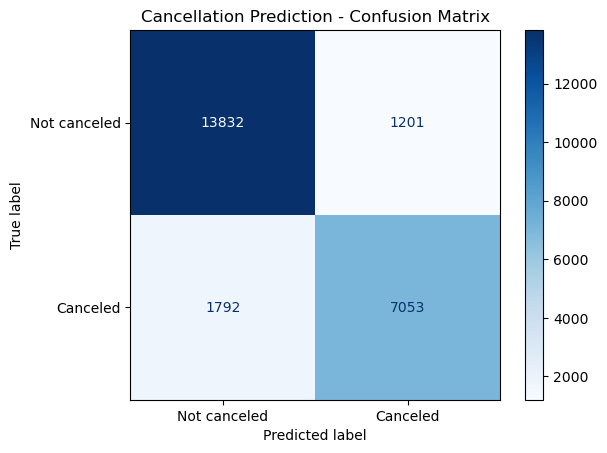

              precision    recall  f1-score   support

Not canceled       0.89      0.92      0.90     15033
    Canceled       0.85      0.80      0.82      8845

    accuracy                           0.87     23878
   macro avg       0.87      0.86      0.86     23878
weighted avg       0.87      0.87      0.87     23878



In [32]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_test, y_pred_test, target_names=["Not canceled", "Canceled"]))

In [33]:
random_search_2.best_params_

{'model__subsample': 1.0,
 'model__reg_lambda': 5,
 'model__reg_alpha': 1,
 'model__n_estimators': 700,
 'model__min_child_weight': 5,
 'model__max_depth': 6,
 'model__learning_rate': 0.1,
 'model__gamma': 0,
 'model__colsample_bytree': 0.8}

ROC-AUC: 0.9493042384199644


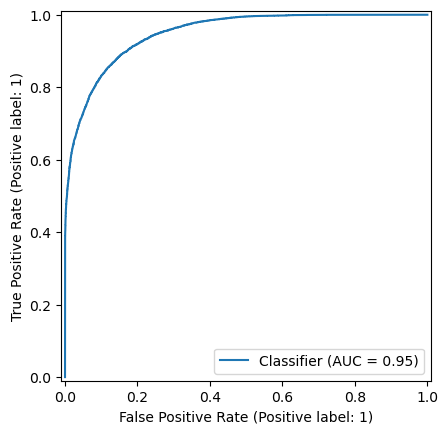

In [34]:
y_probs = tuned_xgb_pipeline_2.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_probs)
print("ROC-AUC:", auc)

RocCurveDisplay.from_predictions(y_test, y_probs)
plt.show();

Let's quickly check the best f1.

Best threshold: 0.41000000000000003
Best F1: 0.8311214333112144


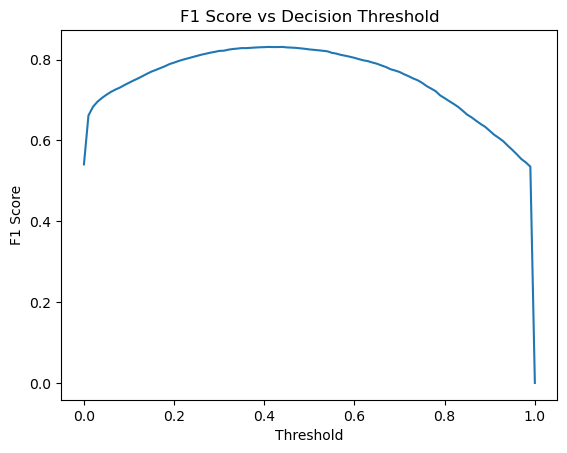

In [35]:
optimal_f1_search(y_test, y_probs)

Now let's just check if the feature importances are roughly similar across models.

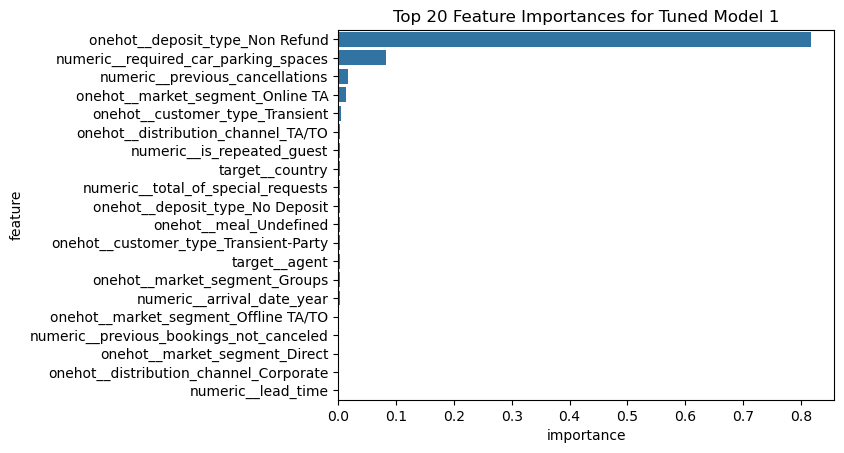

In [36]:
feature_names = tuned_xgb_pipeline.named_steps["preprocessing"].get_feature_names_out()
tuned_xgb_model_1 = tuned_xgb_pipeline.named_steps['model']
importances = tuned_xgb_model_1.feature_importances_

df_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)

sns.barplot(x='importance', y='feature', data=df_imp)
plt.title("Top 20 Feature Importances for Tuned Model 1")
plt.show();

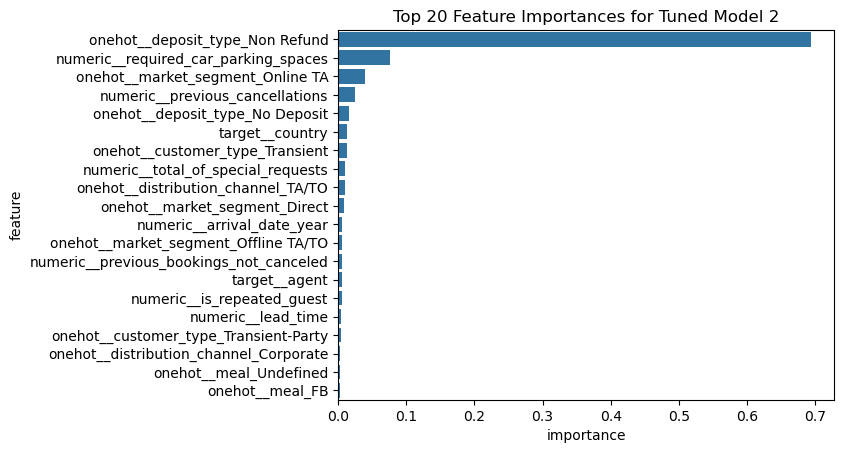

In [37]:
feature_names = tuned_xgb_pipeline_2.named_steps["preprocessing"].get_feature_names_out()
tuned_xgb_model_2 = tuned_xgb_pipeline_2.named_steps['model']
importances = tuned_xgb_model_2.feature_importances_

df_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)

sns.barplot(x='importance', y='feature', data=df_imp)
plt.title("Top 20 Feature Importances for Tuned Model 2")
plt.show();

One feature dominates, but that is normal for XGBoost. We have no reason to remove features, so we will keep them, but it is useful to see these feature importances nonetheless. It also looks like the dominant feature is slightly less important in the second model. The second model has a slightly lower auc, but it overfits much less, and generalizes much better. We can perform one last search with XGBoost now.

In [38]:
# Prevoiusly best hyperparameters (for reference):

# {'model__subsample': 1.0,
#  'model__reg_lambda': 5,
#  'model__reg_alpha': 1,
#  'model__n_estimators': 700,
#  'model__min_child_weight': 5,
#  'model__max_depth': 6,
#  'model__learning_rate': 0.1,
#  'model__gamma': 0,
#  'model__colsample_bytree': 0.8}

In [39]:
param_dist_3 = {
    "model__n_estimators": [700, 800, 1000],
    
    # Shallower trees to avoid overfitting
    "model__max_depth": [5, 6, 7, 8],

    # Lower learning rate so trees are less aggressive
    "model__learning_rate": [0.1, 0.2],

    # Regularization
    "model__min_child_weight": [4, 5, 7],
    "model__gamma": [0, 0.5],

    # Subsampling to prevent memorization
    "model__subsample": [0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 0.9],

    # L1/L2 regularization
    "model__reg_alpha": [0.5, 1, 2],
    "model__reg_lambda": [5, 7, 10],
}

random_search_3 = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist_3,
    n_iter=100,
    cv=3,
    scoring="roc_auc",
    verbose=2,
    n_jobs=1, # Use 1 to avoid potential GPU conflicts
    random_state=42
)

random_search_3.fit(X_train, y_train)

tuned_xgb_pipeline_3 = random_search_3.best_estimator_
tuned_xgb_pipeline_3

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=7, model__n_estimators=700, model__reg_alpha=2, model__reg_lambda=10, model__subsample=1.0; total time=   0.9s
[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=7, model__n_estimators=700, model__reg_alpha=2, model__reg_lambda=10, model__subsample=1.0; total time=   1.0s
[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=7, model__n_estimators=700, model__reg_alpha=2, model__reg_lambda=10, model__subsample=1.0; total time=   0.9s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=7, model__n_estimators=1000, model__reg_alpha=2, model__reg_lambda=5, model__subsample=0.9; total time

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('target', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [40]:
y_pred_train = tuned_xgb_pipeline_3.predict(X_train)
y_pred_test = tuned_xgb_pipeline_3.predict(X_test)

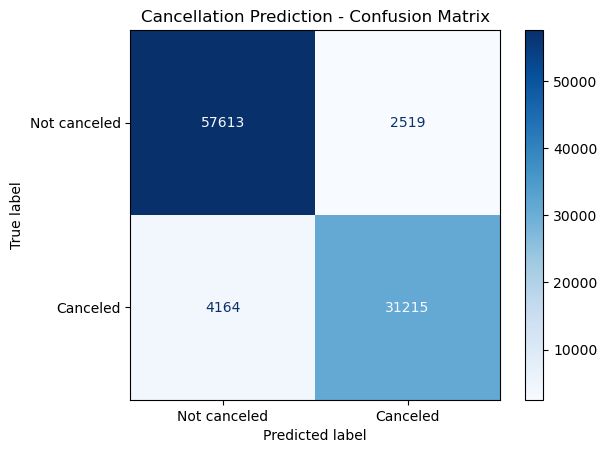

              precision    recall  f1-score   support

Not canceled       0.93      0.96      0.95     60132
    Canceled       0.93      0.88      0.90     35379

    accuracy                           0.93     95511
   macro avg       0.93      0.92      0.92     95511
weighted avg       0.93      0.93      0.93     95511



In [41]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_train, y_pred_train, target_names=["Not canceled", "Canceled"]))

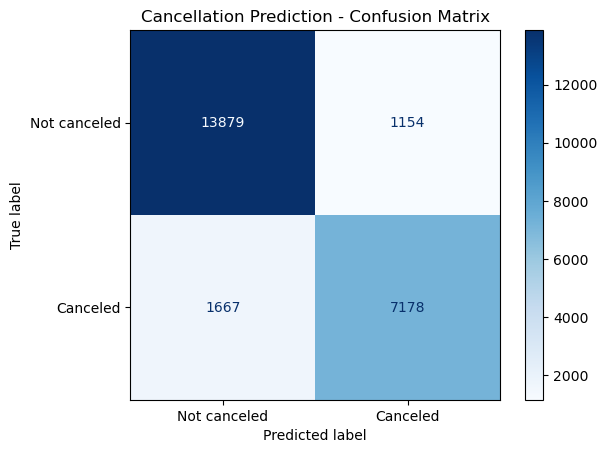

              precision    recall  f1-score   support

Not canceled       0.89      0.92      0.91     15033
    Canceled       0.86      0.81      0.84      8845

    accuracy                           0.88     23878
   macro avg       0.88      0.87      0.87     23878
weighted avg       0.88      0.88      0.88     23878



In [42]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_test, y_pred_test, target_names=["Not canceled", "Canceled"]))

In [43]:
random_search_3.best_params_

{'model__subsample': 1.0,
 'model__reg_lambda': 7,
 'model__reg_alpha': 0.5,
 'model__n_estimators': 1000,
 'model__min_child_weight': 4,
 'model__max_depth': 8,
 'model__learning_rate': 0.1,
 'model__gamma': 0,
 'model__colsample_bytree': 0.9}

ROC-AUC: 0.9535746137092705


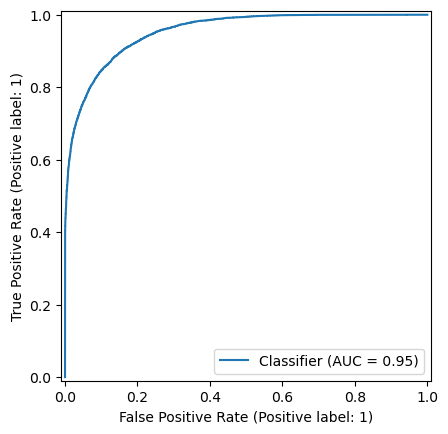

In [44]:
y_probs = tuned_xgb_pipeline_3.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_probs)
print("ROC-AUC:", auc)

RocCurveDisplay.from_predictions(y_test, y_probs)
plt.show();

Best threshold: 0.44
Best F1: 0.8393782383419689


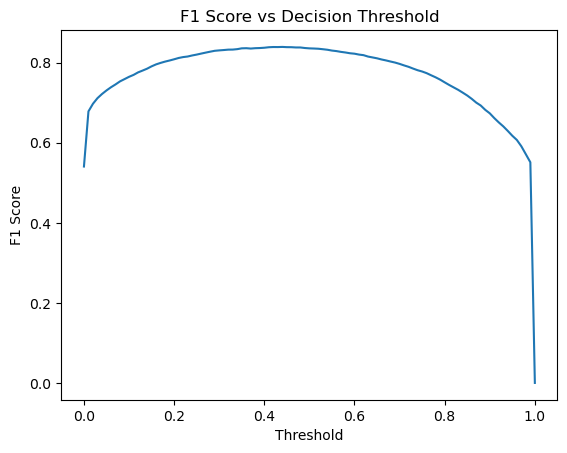

In [45]:
optimal_f1_search(y_test, y_probs)

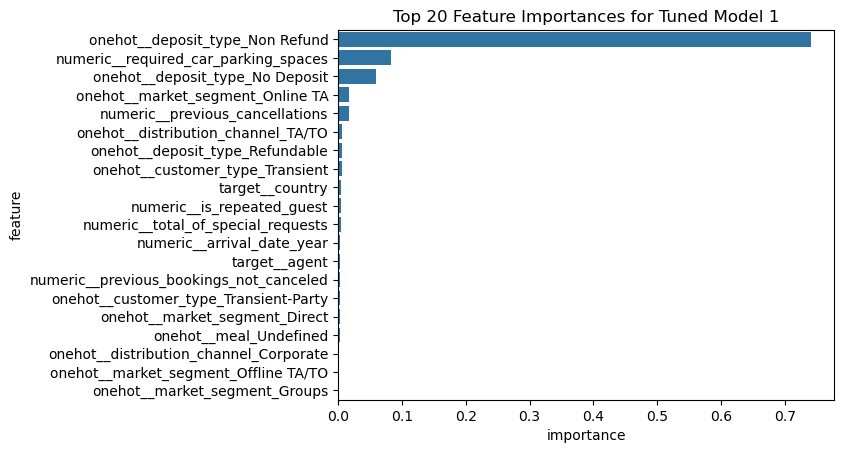

In [46]:
feature_names = tuned_xgb_pipeline_3.named_steps["preprocessing"].get_feature_names_out()
tuned_xgb_model_3 = tuned_xgb_pipeline_3.named_steps['model']
importances = tuned_xgb_model_3.feature_importances_

df_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)

sns.barplot(x='importance', y='feature', data=df_imp)
plt.title("Top 20 Feature Importances for Tuned Model 1")
plt.show();

## Fourth model

We will now try one more model with a few engineered features. We will perform a randomizedsearch like the last one, since adding these few features likely won't change the model by much, but it could give us a small performance boost.

We will need to create a new pipeline first.

In [47]:
data2 = data.copy()

In [2]:
# A function to map week number to season
def week_to_season(week):
    if 10 <= week <= 21:
        return 'Spring'
    elif 22 <= week <= 34:
        return 'Summer'
    elif 35 <= week <= 47:
        return 'Fall'
    else:
        return 'Winter'


In [49]:
# Engineered features
data2["total_stay"] = data2["stays_in_weekend_nights"] + data2["stays_in_week_nights"]
data2["adr_per_person"] = data2["adr"] / (data2["adults"] + data2["children"] + data2["babies"])
data2["arrival_season"] = data2["arrival_date_week_number"].apply(week_to_season)

In [50]:
# total_stay -> numeric
# adr_per_person -> numeric
# arrival_season -> one-hot encoded categorical

In [5]:
# Columns for one-hot encoding (low-cardinality categorical)
onehot_cols = [
    "hotel", "meal", "market_segment", "distribution_channel",
    "customer_type", "deposit_type", "arrival_date_month", "arrival_season"
]

# Columns for target encoding (high-cardinality categorical)
target_cols = ["agent", "country"]

# Numeric / passthrough columns
numeric_cols = [
    "lead_time", "arrival_date_year", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights", "stays_in_week_nights",
    "adults", "children", "babies", "previous_cancellations",
    "previous_bookings_not_canceled", "days_in_waiting_list",
    "adr", "required_car_parking_spaces", "total_of_special_requests",
    "is_repeated_guest", "total_stay", "adr_per_person"
]

# Unincluded columns will be dropped in the preprocessing step

### Preprocessing

In [6]:
# Target encoding for high-cardinality categorical features
target_encoder2 = TargetEncoder(cols=target_cols, smoothing=5)  # CV-safe inside pipeline

# ColumnTransformer
preprocessor2 = ColumnTransformer(
    transformers=[
        ("target", target_encoder2, target_cols),
        ("onehot", OneHotEncoder(handle_unknown="ignore"), onehot_cols),
        ("numeric", "passthrough", numeric_cols)
    ]
)

### Pipeline 2

In [53]:
pipeline2 = Pipeline([
    # preprocessing step
    ("preprocessing", preprocessor2),

    # model step
    ("model", XGBClassifier(
        tree_method="hist",
        # Use GPU
        device="cuda",

        # Basic hyperparameters, will be overridden in hyperparameter tuning
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        eval_metric="logloss"
    ))
])

### Train/Test Split

In [54]:
X = data2.drop("is_canceled", axis=1)
y = data2["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [55]:
# We will use param_dist_3 from previous tuning

random_search_4 = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist_3,
    n_iter=100,
    cv=3,
    scoring="roc_auc",
    verbose=2,
    n_jobs=1, # Use 1 to avoid potential GPU conflicts
    random_state=42
)

random_search_4.fit(X_train, y_train)

tuned_xgb_pipeline_4 = random_search_4.best_estimator_
tuned_xgb_pipeline_4

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=7, model__n_estimators=700, model__reg_alpha=2, model__reg_lambda=10, model__subsample=1.0; total time=   0.9s
[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=7, model__n_estimators=700, model__reg_alpha=2, model__reg_lambda=10, model__subsample=1.0; total time=   1.0s
[CV] END model__colsample_bytree=0.7, model__gamma=0.5, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=7, model__n_estimators=700, model__reg_alpha=2, model__reg_lambda=10, model__subsample=1.0; total time=   0.9s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=7, model__n_estimators=1000, model__reg_alpha=2, model__reg_lambda=5, model__subsample=0.9; total time

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('target', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [56]:
y_pred_train = tuned_xgb_pipeline_4.predict(X_train)
y_pred_test = tuned_xgb_pipeline_4.predict(X_test)

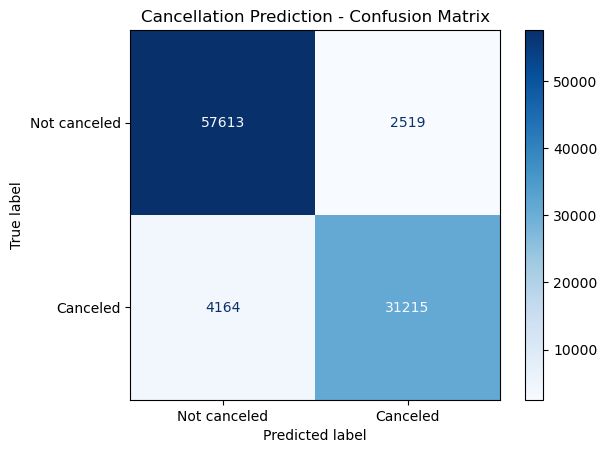

              precision    recall  f1-score   support

Not canceled       0.93      0.96      0.95     60132
    Canceled       0.93      0.88      0.90     35379

    accuracy                           0.93     95511
   macro avg       0.93      0.92      0.92     95511
weighted avg       0.93      0.93      0.93     95511



In [57]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_train, y_pred_train, target_names=["Not canceled", "Canceled"]))

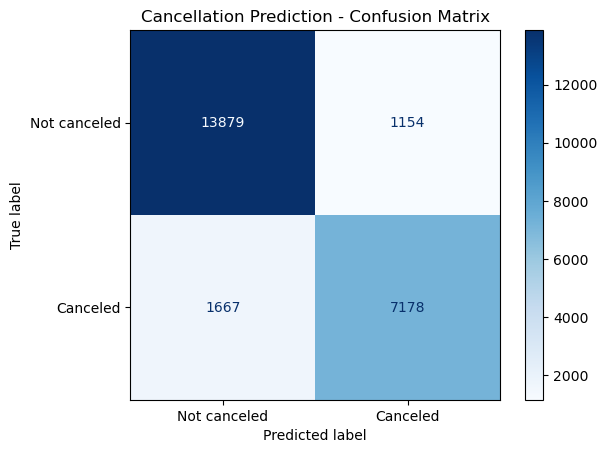

              precision    recall  f1-score   support

Not canceled       0.89      0.92      0.91     15033
    Canceled       0.86      0.81      0.84      8845

    accuracy                           0.88     23878
   macro avg       0.88      0.87      0.87     23878
weighted avg       0.88      0.88      0.88     23878



In [58]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test,
    display_labels=["Not canceled", "Canceled"],
    cmap="Blues",
    normalize=None
)
disp.ax_.set_title("Cancellation Prediction - Confusion Matrix")
plt.show();

print(classification_report(y_test, y_pred_test, target_names=["Not canceled", "Canceled"]))

In [59]:
random_search_4.best_params_

{'model__subsample': 1.0,
 'model__reg_lambda': 7,
 'model__reg_alpha': 0.5,
 'model__n_estimators': 1000,
 'model__min_child_weight': 4,
 'model__max_depth': 8,
 'model__learning_rate': 0.1,
 'model__gamma': 0,
 'model__colsample_bytree': 0.9}

ROC-AUC: 0.9535746137092705


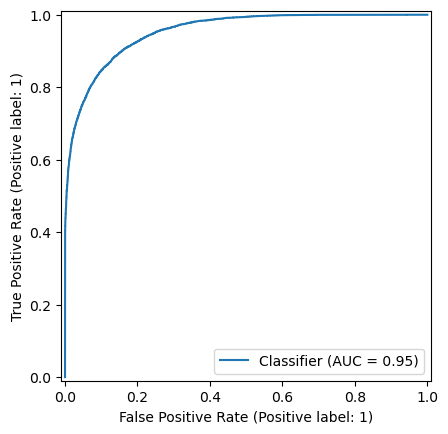

In [60]:
y_probs = tuned_xgb_pipeline_3.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_probs)
print("ROC-AUC:", auc)

RocCurveDisplay.from_predictions(y_test, y_probs)
plt.show();

Best threshold: 0.44
Best F1: 0.8393782383419689


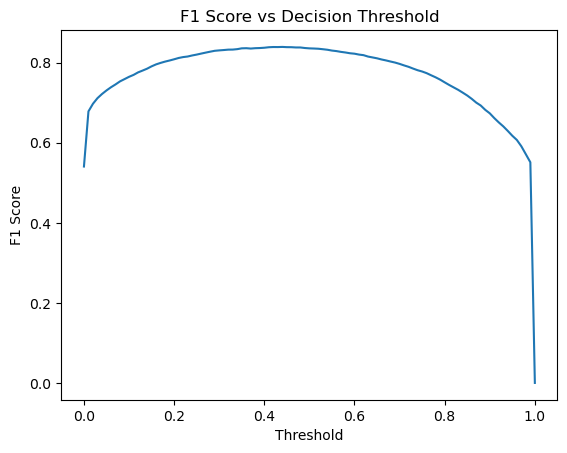

In [61]:
optimal_f1_search(y_test, y_probs)

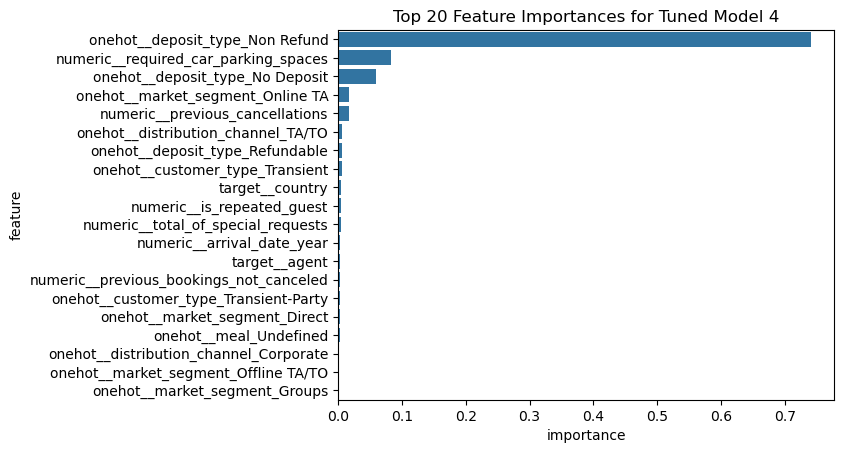

In [62]:
feature_names = tuned_xgb_pipeline_4.named_steps["preprocessing"].get_feature_names_out()
tuned_xgb_model_4 = tuned_xgb_pipeline_4.named_steps['model']
importances = tuned_xgb_model_4.feature_importances_

df_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)

sns.barplot(x='importance', y='feature', data=df_imp)
plt.title("Top 20 Feature Importances for Tuned Model 4")
plt.show();

This model is marginally better. We will adjust the pipeline and save it.

In [3]:
# Custom transformer for engineered features
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # total_stay
        X['total_stay'] = X['stays_in_weekend_nights'] + X['stays_in_week_nights']
        # adr_per_person
        X['adr_per_person'] = X['adr'] / (X['adults'] + X['children'] + X['babies']).replace(0, 1)
        # arrival_season (assumes week_to_season function exists)
        X['arrival_season'] = X['arrival_date_week_number'].apply(week_to_season)
        return X

In [7]:
pipeline_final = Pipeline([
    ("feature_engineering", FeatureEngineer()),
    ("preprocessing", preprocessor2),  # ColumnTransformer with the new features included
    ("model", XGBClassifier(
        tree_method="hist",
        device="cpu",  # "cpu" in production, "cuda" for GPU -> cpu is more flexible
        n_estimators=1000,
        max_depth=8,
        learning_rate=0.1,
        subsample=1.0,
        colsample_bytree=0.9,
        gamma=0,
        reg_alpha=0.5,
        reg_lambda=7,
        min_child_weight=4,
        random_state=42,
        eval_metric="logloss"
    ))
])

In [14]:
pipeline_final.fit(X_train, y_train)

,steps,"[('feature_engineering', ...), ('preprocessing', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('target', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
joblib.dump(pipeline_final, "../../models/xgb_cancellation_model_final.joblib")

['../../models/xgb_cancellation_model_final.joblib']

We can also save the feature importances and the global shap values of the test set.

In [66]:
df_imp_all = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

df_imp_all

,feature,importance
27,onehot__deposit_type_Non Refund,0.740314
54,numeric__required_car_parking_spaces,0.082731
26,onehot__deposit_type_No Deposit,0.059421
15,onehot__market_segment_Online TA,0.017085
50,numeric__previous_cancellations,0.016694
20,onehot__distribution_channel_TA/TO,0.006696
28,onehot__deposit_type_Refundable,0.006307
24,onehot__customer_type_Transient,0.005736
1,target__country,0.004429
56,numeric__is_repeated_guest,0.003830


In [67]:
df_imp_all.to_csv("../../models/xgb_cancellation_model_feature_importances.csv", index=False)

In [69]:
X_sample = X_test.copy()
X_sample.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card,total_stay,adr_per_person,arrival_season
93581,City Hotel,83,2016,July,30,23,0,1,2,0,...,1,Check-Out,2016-07-24,Karina Hart,Karina.Hart21@verizon.com,423-362-0485,************9464,1,52.650002,Summer
118099,City Hotel,146,2017,August,32,12,2,1,3,0,...,2,Check-Out,2017-08-15,Paul Flores,PaulFlores@hotmail.com,674-283-5392,************5220,3,58.500000,Summer
56242,City Hotel,120,2016,September,36,1,1,3,2,0,...,0,Canceled,2016-05-17,Emily Rivera,Rivera_Emily@aol.com,381-806-2174,************3972,4,59.400002,Fall
38448,Resort Hotel,106,2017,July,29,17,1,0,2,0,...,2,Check-Out,2017-07-18,Jeffrey Melton,Jeffrey.Melton@zoho.com,898-951-1226,************6560,1,129.500000,Summer
87074,City Hotel,45,2016,April,16,11,1,2,2,2,...,2,Check-Out,2016-04-14,Steven Combs,Steven_Combs@yandex.com,521-241-1861,************6157,3,44.325001,Spring


In [72]:
X_transformed = pipeline_final[:-1].transform(X_sample)

In [73]:
xgb_model = pipeline_final.named_steps['model']

explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer(X_transformed)

In [77]:
onehot_feature_names = pipeline_final.named_steps['preprocessing'].named_transformers_['onehot'].get_feature_names_out()
feature_names = np.concatenate([target_cols, onehot_feature_names, numeric_cols])

print(feature_names.shape)

(63,)


In [78]:
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
shap_df

,agent,country,hotel_City Hotel,hotel_Resort Hotel,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Aviation,...,babies,previous_cancellations,previous_bookings_not_canceled,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_repeated_guest,total_stay,adr_per_person
0,-0.141016,1.488765,-0.053507,-0.011952,0.012713,0.001706,0.006957,-0.019399,0.014613,-0.002124,...,-0.000686,-0.090846,0.045626,0.008209,0.025474,0.118680,-0.647849,0.007148,-0.033253,-0.014503
1,0.528045,-0.328342,-0.005523,-0.000045,-0.014000,0.001734,-0.011070,-0.004071,0.005125,-0.001309,...,0.001369,-0.060188,0.028812,0.007198,0.322429,0.102368,-1.035025,0.005775,0.000995,-0.052363
2,0.895612,0.024777,0.016446,0.000774,0.026401,0.001899,0.000285,0.089931,0.007743,-0.001971,...,-0.002979,-0.060685,0.027175,0.009944,0.178784,0.114274,1.006481,0.003950,-0.016671,0.069973
3,0.441507,0.717053,0.106788,-0.000725,-0.017099,0.002686,-0.004106,0.009547,0.009617,-0.001150,...,0.001430,-0.084013,0.040295,0.008828,-0.336787,0.124894,-1.578191,0.006315,-0.101623,-0.227230
4,0.525937,-0.741144,0.022398,0.005732,-0.008690,0.002502,0.008992,-0.015262,0.005432,-0.000454,...,0.001078,-0.054918,0.027260,0.007019,0.112103,0.096584,-1.334921,0.005514,-0.071469,0.171151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23873,-1.039138,-0.709978,-0.005337,-0.003329,0.013262,0.002005,0.010100,0.010921,0.011574,-0.002747,...,0.001969,-0.083026,0.037963,0.009563,-0.219392,0.082139,0.779543,0.007667,-0.013126,-0.169616
23874,0.612759,2.600143,-0.088731,-0.007302,0.054932,0.001029,0.151812,-0.000630,0.012877,-0.001996,...,-0.000759,-0.137671,0.036671,0.002139,0.131824,0.101375,1.155020,0.006637,-0.058505,0.447833
23875,-1.138230,1.943821,-0.020475,-0.001204,-0.031221,0.001706,-0.001834,0.017497,0.016678,-0.000940,...,-0.000628,-0.097218,0.044819,0.014371,-0.073039,0.114653,0.320440,0.004311,-0.045582,-0.294343
23876,-2.110694,-2.396687,0.073256,-0.021741,0.059563,0.001180,0.027756,-0.016533,0.006686,-0.001796,...,0.000745,-0.066592,0.027880,0.007636,0.183822,0.070030,0.418768,0.004578,-0.119145,0.053418


In [79]:
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)
shap_df_global = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': shap_abs_mean
}).sort_values(by='mean_abs_shap', ascending=False)

shap_df_global

,feature,mean_abs_shap
1,country,1.283046
27,deposit_type_Non Refund,0.953624
0,agent,0.836277
59,total_of_special_requests,0.628102
45,lead_time,0.557502
...,...,...
19,distribution_channel_GDS,0.001986
28,deposit_type_Refundable,0.000713
23,customer_type_Group,0.000324
16,market_segment_Undefined,0.000000


In [80]:
shap_df_global.to_csv("../../models/xgb_cancellation_model_shap_importances.csv", index=False)

We can now use global shap values and feature importances for faster responses in production.

### END OF FILE